기한: 12월 29일 (금) 18시 30분

과제: 파이썬 머신러닝 완벽가이드 ch7. 6 pg. 452~465 

필사하여 깃허브에 업로드하고, 깃허브 링크를 댓글로 달아주세요.

## 7-06. 군집화 실습 - 고객 세그먼테이션

----------------
### 고객 세그먼테이션의 정의와 기법

- 고객 세그먼테이션 (Customer Segmentation) : 다양한 기준으로 고객을 분류하는 기법. 고객 세그먼테이션은 CRM이나 마케팅의 중요 기반 요소이다.
- 고객 세그먼테이션은 고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요한데, 여기서는 기본적인 고객 분석 요소인 RFM 기법을 이용할 것이다.

<RFM 기법>
- Recency (R) : 가장 최근 상품 구입일에서 오늘까지의 기간
- Frequency (F) : 상품 구매 횟수
- Monetary Value (M) : 총 구매 금액
----------------------

### 데이터 세트 로딩과 데이터 클렌징

In [3]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io = './data/Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- Problem : CustomerID 칼럼의 null값이 너무 많다.
- Solution : 고객 세그먼테이션을 수행하므로 고객 식별 번호가 필요 없으므로 삭제.

- Problem : 오류 데이터 존재. Quantity 또는 UnitPrice가 0보다 작은 경우.
- Solution : 삭제. Quantity > 0, UnitPrice > 0 이고 CustomerID가 not null인 값만 필터링

In [9]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(354321, 9)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
sale_amount    0
dtype: int64

------------
Country 칼럼은 대부분이 영국이므로 다른 국가의 데이터는 제거

In [6]:
retail_df['Country'].value_counts()

United Kingdom          354321
Germany                   9040
France                    8341
EIRE                      7236
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

In [7]:
retail_df = retail_df[retail_df['Country'] == 'United Kingdom']
print(retail_df.shape)

(354321, 8)


----------------
### RFM 기반 데이터 가공

Unitprice와 Quantity를 곱해서 주문 금액 데이터를 만든다.

CustomerNo도 식별을 위해 float을 int형으로 바꾼다.

In [8]:
retail_df['sale_amount'] = retail_df['UnitPrice'] * retail_df['Quantity']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

---------
이 데이터 세트는 특정 고객의 주문 횟수와 주문 금액이 압도적으로 크다는 특성을 갖는다. 이는 개인 고객과 소매점의 주문이 함께 포함되어 있기 때문이다. Top5 주문건수와 주문금액을 갖는 고객의 데이터를 추출해보자

In [11]:
print(retail_df['CustomerID'].value_counts().head())
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


----------
InvoiceNo + StockCode로 groupby하면 거의 1에 가깝게 유일한 식별자 레벨이 된다.
- InvoiceNo(주문번호)
- StockCode(상품코드)


In [15]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

InvoiceNo  StockCode
536365     21730        1
           22752        1
           71053        1
           84029E       1
           84029G       1
                       ..
581585     84946        1
581586     20685        1
           21217        1
           22061        1
           23275        1
Name: InvoiceNo, Length: 344435, dtype: int64

-------
지금 수행하는 RFM 기반의 고객 세그먼테이션은 고객 레벨로 '주문 기간', '주문 횟수', '주문 금액' 데이터를 기반으로 하여 세그먼테이션을 수행하려는 것이다. 따라서 주문번호 + 상품코드 기준의 데이터를 고객 기준의 RFM 데이터로 변경한다. 이를 위해서는 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 groupby 해야한다. 주문 번호 기준의 retail_df에 'customerID'를 기준으로 groupby한 데이터프레임을 새롭게 생성한다.

DataFrame의 groupby()만 사용해서는 여러 개의 칼럼에 서로 다른 aggregation 연산을 수행하기 어렵다 (count, mean, max 등) 따라서 groupby로 호출된 DataFrameGroupBy 객체에 agg()를 이용한다. agg()에 인자로 대상 칼럼들과 aggregation 함수명을 딕셔너리 형태로 입력하면 여러 개의 aggregation 연산을 수행할 수 있다.
- Frequency (고객별 주문 건수) : 'CustomerID'로 groupby()하여 'InvoiceNo'에 count()
- Recency (가장 최근 상품 구입일에서 오늘까지의 기간) : 'CustomerID'로 groupby()하여 'InvouceDate' 칼럼에 max()한 이후 별도 가공
- Monetary Value (고객별 주문 고객) : 'CustomerID'로 groupby()하여 'sale_amount'에 sum()

In [17]:
# DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 칼럼의 max()에서 데이터를 가공한다.
# Frequency는 InvoiceNo 칼럼의 count(), Monetary Value는 sale_amount() 칼럼의 sum()

aggregations = { 
    'InvoiceDate' : 'max', 
    'InvoiceNo' : 'count', 
    'sale_amount' : 'sum'
    }

cust_df = retail_df.groupby('CustomerID').agg(aggregations)

# groupby된 결과의 칼럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns={'InvoiceDate' : 'Recency', 
                                  'InvoiceNo' : 'Frequency',
                                  'sale_amount' : 'Monetary'})
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


---------
Recency 칼럼 추가 데이터 가공 필요 : 여기서 오늘 날짜를 현재 날짜로 해서는 안 된다. 2011년 12월 10일로 간주한다.

In [18]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 칼럼 건수는', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는 (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


-------
### RFM 기반 고객 세그먼테이션

해당 데이터 세트는 일반 개인 고객 주문 뿐만 아니라 소매업체의 대규모 주문을 포함하고 있다. 따라서 주문 횟수와 주문 금액에 있어 큰 차이를 보이기 때문에 왜곡된 데이터 분포도를 가지게 되어 군집화가 한쪽 군집에만 집중되는 현상이 발생한다.

먼저 해당 데이터 세트의 칼럼별 히스토그램을 확인하고, 이처럼 왜곡된 데이터 분포도에서 군집화를 수행할 때 나타나는 현상에 대해 알아보자.

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

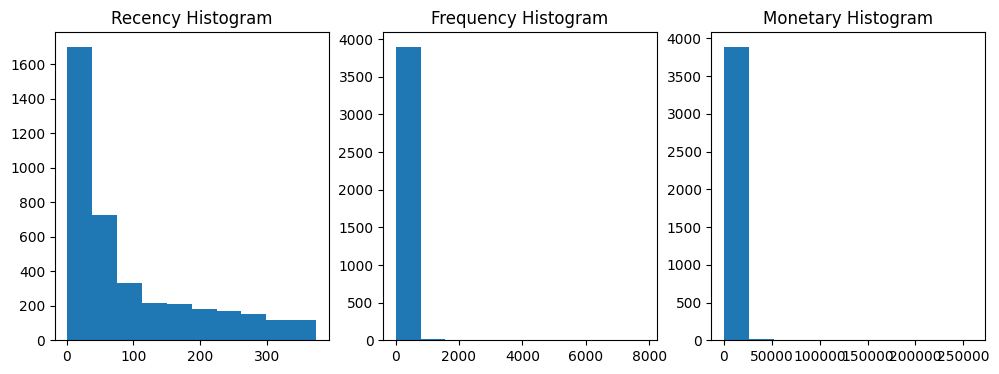

In [19]:
# Recency, Frequency, Monetary 칼럼 값 분포 히스토그램

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12,4), nrows=1, ncols = 3)

ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

In [20]:
# 각 칼럼의 데이터값 백분위
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


----------------
이처럼 왜곡도가 높은 데이터 세트에 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행된다.

In [21]:
# Standard Scaler로 평균 표준편차를 재조정 한 뒤 K-평균 수행
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

C:\Users\홍예원\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


실루엣 스코어는 : 0.592


군집을 3개로 구성할 경우 전체 군집의 평균 실루엣 계수인 실루엣 스코어는 0.592로 안정적이다. 하지만 각 군집별 실루엣 계수 값은 다음과 같다.


In [22]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [24]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

C:\Users\홍예원\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\홍예원\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\홍예원\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\홍예원\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default valu

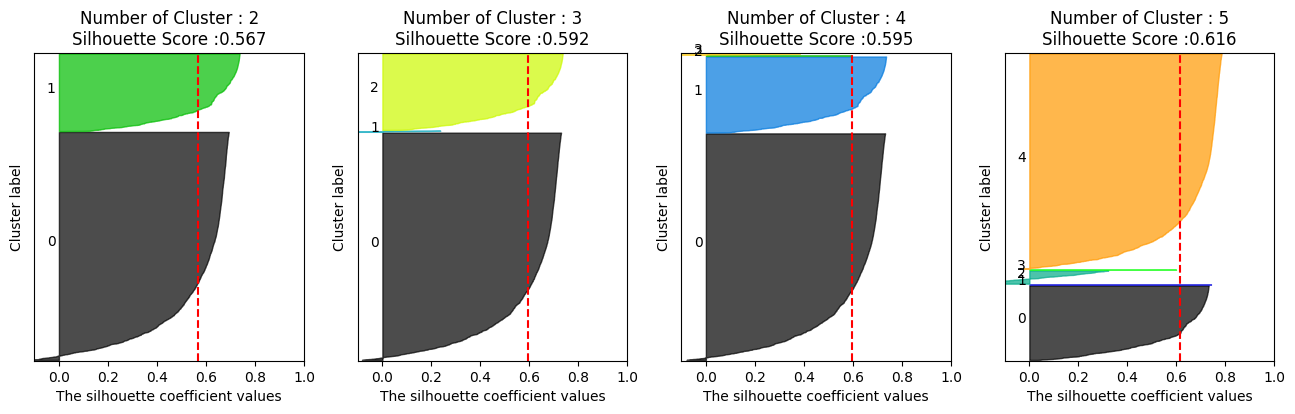

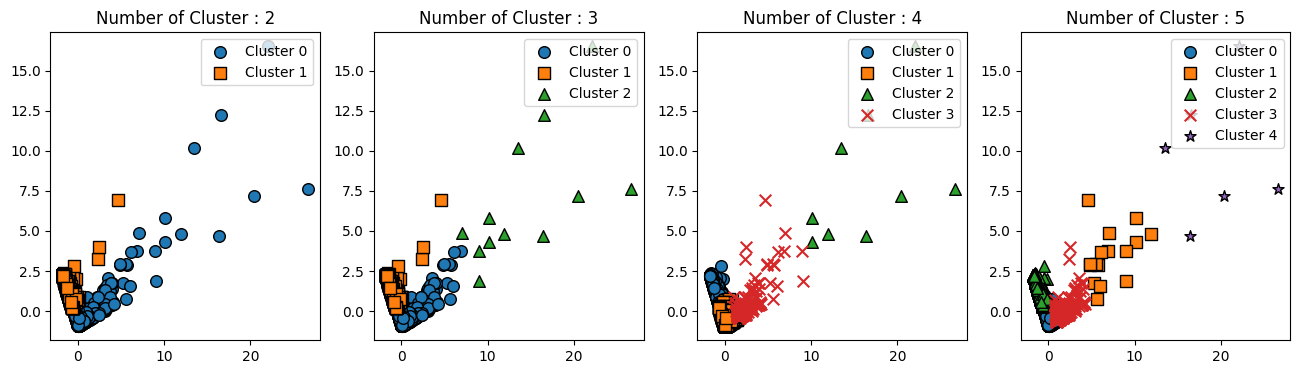

In [25]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

군집이 2개일 경우 너무 개괄적으로 군집화되었다. 군집수를 증가시켜도 개선되지 않는다. 군집이 3개 이상일 때는 데이터 세트의 개수가 너무 작은 군집이 만들어진다.

-----------------
왜곡 정도를 낮추기 위해 로그 변환 후 K-평균 알고리즘을 적용해보자

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# RFM 칼럼에 np.log1p()로 log transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 standard scaler 적용
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)

cust_df['cluster_label'] = labels
print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

C:\Users\홍예원\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


실루엣 스코어는 : 0.303


C:\Users\홍예원\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\홍예원\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\홍예원\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\홍예원\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default valu

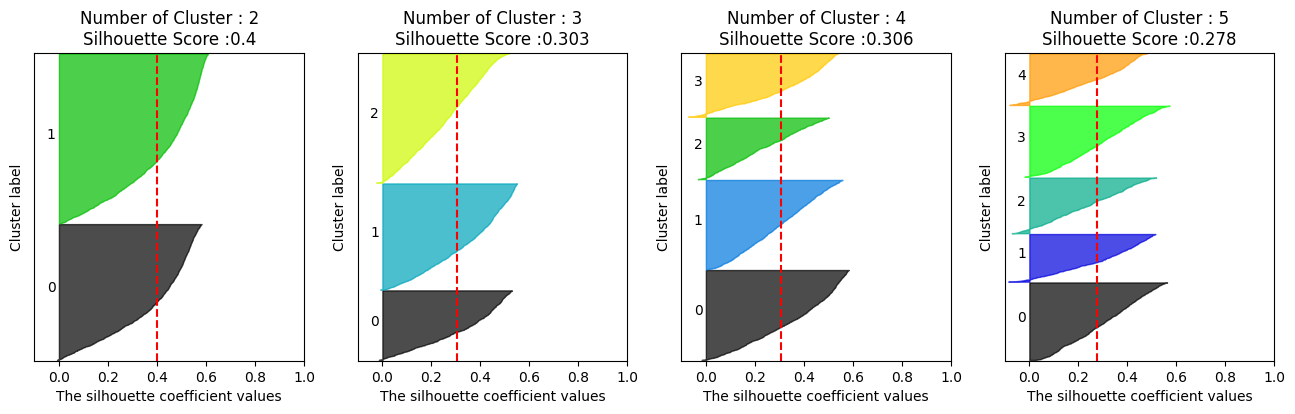

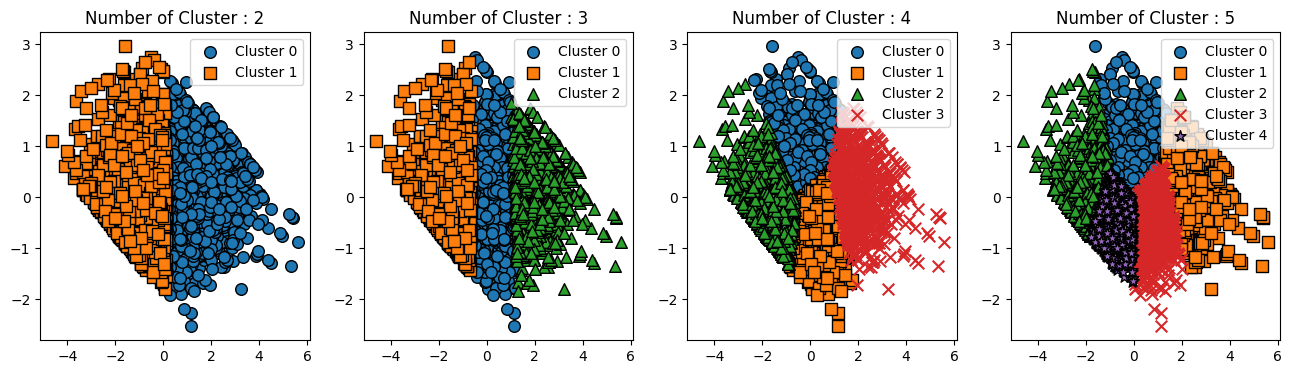

In [28]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

실루엣 스코어는 로그 변환하기 전보다 떨어지지만 앞의 경우보다 더 균일하게 군집화되었음을 알 수 있다.